# Techniques to Make Neural Networks Train Better
In this exercise, we will go over common ways people improve the performance of their neural networks. Our dataset will be a toy example based on circles. We will take a look at,

- Dropout
- Batch Normalization
- Layer Normalization

In [ ]:
# Necessary imports
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Parametric circle
theta = np.linspace(0, 2 * np.pi, 100)
def get_circle(h, k, r):
    x = h + r * np.cos(theta) 
    y = k + r * np.sin(theta)
    return x, y

In [ ]:
x1, y1 = get_circle(2, 3, 4)
x2, y2 = get_circle(1, 4, 2)

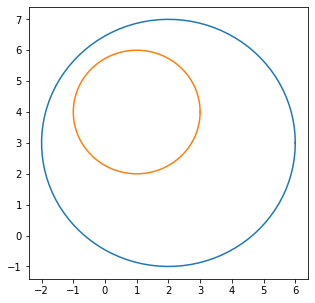

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.show()

In [ ]:
x_t, y_t = np.random.uniform(-2, 6, 500), np.random.uniform(-1, 7, 500)

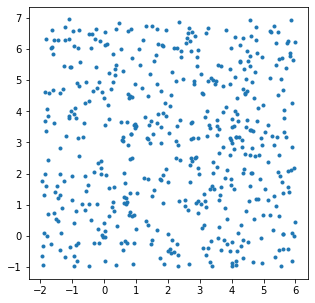

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(x_t, y_t, '.')
plt.show()

In [ ]:
inner = []
outer = []
# Stuff to make a weird classification problem
for x, y in zip(x_t, y_t):
    if (x - 1) ** 2 + (y - 4) ** 2 <= 1:
        outer.append([x, y])
    elif (x - 1) ** 2 + (y - 4) ** 2 <= 4:
        inner.append([x, y])
    elif (x - 3) ** 2 + (y - 4) ** 2 <= 5:
        outer.append([x, y])
    elif (x - 1) ** 2 + (y - 4) ** 2 > 4 and (x - 2) ** 2 + (y - 3) ** 2 <= 16:
        inner.append([x, y])
inner = np.array(inner)
outer = np.array(outer)

In [ ]:
inner.shape, outer.shape

((268, 2), (127, 2))

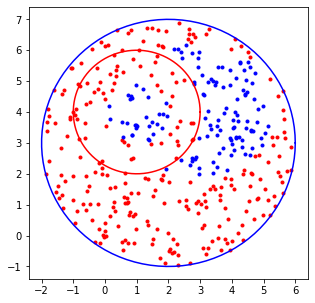

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(inner[:, 0], inner[:, 1], 'r.')
plt.plot(outer[:, 0], outer[:, 1], 'b.')
plt.plot(x1, y1, 'b')
plt.plot(x2, y2, 'r')
plt.show()

In [ ]:
x_train = np.concatenate((inner, outer))
y_train = np.concatenate((np.ones(len(inner)), np.zeros(len(outer))))
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

## Dropout
We can regularize and speed up the training times of our network by randomly "dropping" hidden units during training. This helps prevent the network from overfitting by encouraging it to learn robust representations by solving *co-adaptation* where later units correct for earlier units, thereby preventing those earlier units from learning better representations. This is because the earlier units can no longer expect later units to be present. This can be achieved via [Dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks)#Dropout) and is also a very common technique to improve network performance.

### Training
When adding dropout to a layer during training, we randomly mask out a hidden unit with some probability $p$, which is a hyperparameter. Higher values of $p$ correspond to more regularization. Dropping a hidden unit can be implemented by zeroing out a row of the weights matrix, $W$. So,

$$W_j=\begin{cases}
W_j,\quad &\text{with probability }1-p\\
0,\quad   &\text{otherwise}
\end{cases}$$

This leads to the fascinating effect of our network architecture being different at each step of training. While this may seem to introduce instability, it has been experimentally shown to be effective.

After we have dropped units, we can rescale the distribution of activations to preserve their expected value by ensuring their sum is the same. This amounts to multiplying the remaining activations by $\frac{1}{1-p}$. This is known as inverted dropout.

## Inference
In inverted dropout, we simply keep all units without modification during inference. If we did not rescale our activations during training, we then multiply our activations by $1-p$ to scale properly. Keras uses inverted dropout.

## Advantages and Disadvantages
- Advantages
 - Prevents overfitting.
 - Good for small datasets (check your validation loss without dropout to see if it's necessary).
 - Computationally cheap.
- Disadvantages
 - Don't put before the last layer since it can't be accounted for in future layers.
 - Usually shouldn't be used with a small network.
 - Accuracy may be low if not trained until convergence since it pushes the network to learn robust representations.

In [ ]:
w = tf.random.normal((4, 3))
tf.print(w)

[[0.644480824 -0.552343845 0.492081374]
 [-0.321095437 -0.0945952609 -1.09974957]
 [0.557846069 0.569595516 1.04263818]
 [-0.264266878 0.665669501 1.28469479]]


In [ ]:
tf.print(tf.nn.dropout(w, 0.5))

[[1.28896165 -0 0]
 [-0 -0.189190522 -2.19949913]
 [0 1.13919103 0]
 [-0 1.331339 0]]


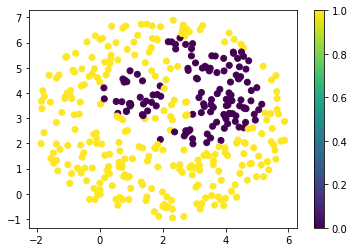

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.colorbar()
plt.show()

In [ ]:
# ReLU Network: 256 -> 128 -> 64 -> 1
# Demonstrate vanilla vs dropout w/ p=0.3, batch size 32, lr=1e-3, mom=0.9
# Epochs 1000 vs 2000
model = tfk.Sequential(
    [
     tfkl.Dense(256, input_shape=(2,), activation='relu'),
     tfkl.Dropout(0.3),
     tfkl.Dense(128, activation='relu'),
     tfkl.Dropout(0.3),
     tfkl.Dense(64, activation='relu'),
     tfkl.Dense(1, activation='sigmoid')
    ]
)

opt = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               768       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41,985
Trainable params: 41,985
Non-trai

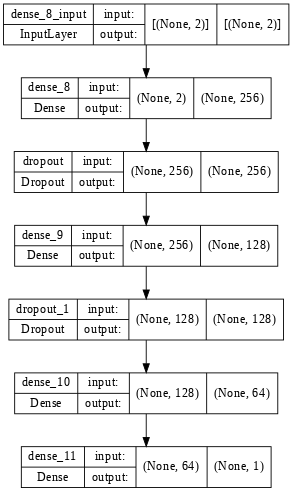

In [ ]:
tfk.utils.plot_model(model, dpi=64, show_shapes=True)

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7053
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6951
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6849
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6588
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6474
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6273
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6269
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6122
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6055
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6168
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6024
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5930
Epoch 13/1000
13/13 [====

We can see after 1000 epochs, the vanilla neural network learns a fairly decent representation of the problem.

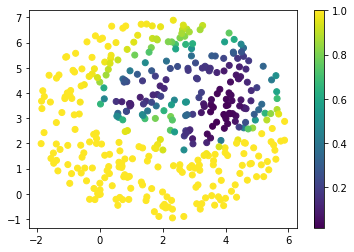

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=model.predict(x_train))
plt.colorbar()
plt.show()

Using dropout, we can see the differences are very subtle. To me, it appears that color gradient is somewhat smoother for dropout - possibly as a result of regularization.

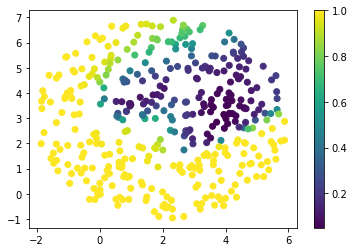

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=model.predict(x_train))
plt.colorbar()
plt.show()

## Batch Normalization
We can improve the stability and speed of training by rescaling the inputs to a layer to have zero mean and unit variance. This can be achieved via [Batch Normalization](https://en.wikipedia.org/wiki/Batch_normalization) and has been empirically shown to be effective and is one of the most popular techniques used to improve neural network performance.

### Training
It is impractical to compute the population mean and variance during every step of training, so we compute empirical means and variances from a minibatch $B$ of size $m$. Given an input $x_i$ (the activations from the previous layer, but also sometimes before the activation function),

$$\mu_B=\frac{1}{m}\sum_{i=1}^mx_i,\quad\sigma_B^2=\frac{1}{m}\sum_{i=1}^m(x_i-\mu_B)^2$$

We do this rescaling on each dimension separately so note that $x_i=(x_i^{(1)},\dots,x_i^{(d)})$. We rescale with standardization,

$$\hat{x}_i=\frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$$

Here, $\epsilon$ is a small positive hyperparameter that is included for numerical stability ($\sigma_B=0$). The authors introduce two learnable, scalar parameters $\gamma,\beta$ to "restore the representation power" of the network. If our input is scaled to zero mean and unit variance, it may obscure layer representations by, for example, limiting the output to a subset of the activation function. We apply the transformation as,

$$y_i=\gamma\hat{x}_i+\beta$$

$y_i$ is what is passed as the input into the layer while $\hat{x}_i$ remains internal. Then batch normalization is the transformation: $\text{BN}_{\gamma,\beta}:x_{1\dots m}\to y_{1\dots m}$. This process is end-to-end differentiable so the parameters $\gamma,\beta$ are learned during backpropagation.

### Inference
We want deterministic results from our network during inference, so we cannot compute our statistics on minibatches but over our whole dataset. Therefore, we want statistics,

$$\mathbb{E}[x]=\mathbb{E}_B[\mu_B],\quad\mathbb{V}[x]=\frac{m}{m-1}\mathbb{E}_B[\sigma_B^2]$$

This is implemented in Keras via an exponential moving average that is computing during each training step, and thus will be deterministic during inference. The population statistics are estimated with,

$$\mathbb{E}[x]=\alpha\mathbb{E}[x]+(1-\alpha)\mu_B,\quad\mathbb{V}[x]=\alpha\mathbb{V}[x]+(1-\alpha)\sigma_B^2$$

Here, $\alpha\in[0,1]$ is a momentum hyperparameter. Since our statistics are now fixed, batch normalization during inference is the linear transformation,

$$\text{BN}_{\gamma,\beta}^\text{inf}(x)=\gamma\frac{x-\mathbb{E}[x]}{\sqrt{\mathbb{V}[x]+\epsilon}}+\beta$$

### Why Does It Work?
The short answer is we don't really know. The original authors claimed it reduce "internal covariate shift," meaning as the network trains and updates its parameters, the distribution of its layer activations changes. Batch normalization then reduces this instability by rescaling inputs between layers. However, this explanation has been called into question in recent years and now it is thought batch normalization functions by effectively smoothing out the error surface (smaller Lipschitz constant), making training easier.

### Advantages and Disadvantages
This list modified from this [post](https://machinelearningknowledge.ai/keras-normalization-layers-explained-for-beginners-batch-normalization-vs-layer-normalization).

- Advantages
 - Networks train faster and learn better.
 - Functions as regularization.
 - Works well with feedforward and convolutional neural networks.
 - Used in vision tasks.
- Disadvantages
 - Requires a decently-sized minibatch size.
 - Does not work well with recurrent neural networks.

In [ ]:
# ReLU Network: 256 -> 128 -> 64 -> 1
# Demonstrate vanilla vs dropout w/ p=0.3, batch size 32, lr=1e-3, mom=0.9
# Epochs 1000 vs 2000
model = tfk.Sequential(
    [
     tfkl.Dense(256, input_shape=(2,), activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(128, activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(64, activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(1, activation='sigmoid')
    ]
)

opt = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=500)

Epoch 1/500
13/13 [==============================] - 1s 2ms/step - loss: 0.6723
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.4304
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3864
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3827
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3405
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3190
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3424
Epoch 8/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3031
Epoch 9/500
13/13 [==============================] - 0s 2ms/step - loss: 0.2887
Epoch 10/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3051
Epoch 11/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2766
Epoch 12/500
13/13 [==============================] - 0s 2ms/step - loss: 0.3047
Epoch 13/500
13/13 [=================

After 500 epochs with batch normalization, we can see the network learns a better representation than either the vanilla or dropout network.

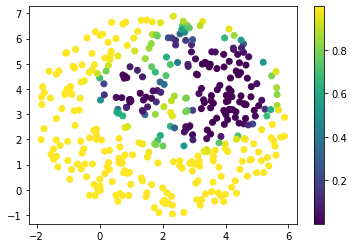

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=model.predict(x_train))
plt.colorbar()
plt.show()

## Layer Normalization
Layer normalization is somewhat similar in construction to batch normalization, however it addresses some of its issues by normalizing over the intermediate activations (before we apply the activation function) of each hidden unit in a layer rather than over the minibatch. It is thus independent of batch size.

### Training
In layer normalization, we compute a mean and variance within our layer for *each sample* (more precisely, its intermediate activation). Thus, we compute our statistics for $H$ hidden units in a layer $l$ for an intermediate activation $a_i=(a_i^{(1)},\dots,a_i^{(H)})$,

$$\mu_i^l=\frac{1}{H}\sum_{j=1}^H a_i^{(j)},\quad \sigma_i^l=\sqrt{\frac{1}{H}\sum_{j=1}^H(a_i^{(j)}-\mu_i^l)^2}$$

Note that $\mu^l$ does not denote an exponent but rather an identifier for the layer. We standardize as,

$$\hat{a}_i=\frac{a_i-\mu_i^l}{\sqrt{(\sigma_i^l)^2+\epsilon}}$$

Lastly, we introduce parameters $\gamma^l=(\gamma_1^l,\dots,\gamma_H^l)$ and $\beta^l=(\beta_1^l,\dots,\beta_H^l)$ as vectors over each hidden unit and apply the transformation,

$$y_i=\gamma^l⊙\hat{a}_i+\beta^l$$

This is then used to compute the final activation of the layer with activation function $f$,

$$h_i^{l+1}=f(y_i)$$

For a minibatch of size $m$, $\mu^l$ and $\sigma^l$ would be vectors of size $m$ as they normalize for each sample. Thus, layer normalization is the transformation: $\text{LN}_{\gamma_{1\dots H}^l,\beta_{1\dots H}^l}^l:a_{1\dots m}\to y_{1\dots m}$.

### Inference
Unlike batch normalization, there is no difference in the training and inference steps for layer normalization so we do not need to introduce any moving averages. During inference, we simply compute $\mu^l$ and $\sigma^l$ from the inputs.

### Advantages and Disadvantages
- Advantages
 - Not dependent on batch size.
 - Works for recurrent neural networks.
 - Used in NLP tasks (but increasingly in vision transformers).
- Disadvantages
 - Does not work well for convolutional neural networks.

In [ ]:
# Demonstrate LayerNorm vs BatchNorm for batch size 8
# ReLU Network: 256 -> 128 -> 64 -> 1
# Demonstrate vanilla vs dropout w/ p=0.3, batch size 32, lr=1e-3, mom=0.9
# Epochs 1000 vs 2000
model = tfk.Sequential(
    [
     tfkl.Dense(256, input_shape=(2,), activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(128, activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(64, activation='relu'),
     tfkl.BatchNormalization(),
     tfkl.Dense(1, activation='sigmoid')
    ]
)

opt = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
model.fit(x_train, y_train, batch_size=8, epochs=500)

Epoch 1/500
50/50 [==============================] - 1s 2ms/step - loss: 0.5763
Epoch 2/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4490
Epoch 3/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4312
Epoch 4/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4229
Epoch 5/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4375
Epoch 6/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4340
Epoch 7/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4082
Epoch 8/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4932
Epoch 9/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3999
Epoch 10/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3835
Epoch 11/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4191
Epoch 12/500
50/50 [==============================] - 0s 2ms/step - loss: 0.4130
Epoch 13/500
50/50 [=================

After downsizing the batch size to 8, we can see the batch normalization network has a tougher time learning the geometry of the problem.

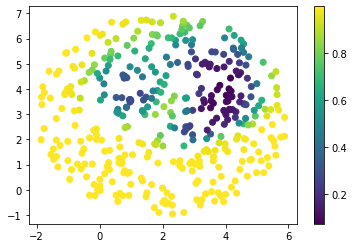

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=model.predict(x_train))
plt.colorbar()
plt.show()

In [ ]:
model = tfk.Sequential(
    [
     tfkl.Dense(256, input_shape=(2,)),
     tfkl.LayerNormalization(),
     tfkl.ReLU(),
     tfkl.Dense(128),
     tfkl.LayerNormalization(),
     tfkl.ReLU(),
     tfkl.Dense(64),
     tfkl.LayerNormalization(),
     tfkl.ReLU(),
     tfkl.Dense(1, activation='sigmoid')
    ]
)

opt = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
model.fit(x_train, y_train, batch_size=8, epochs=500)

Epoch 1/500
50/50 [==============================] - 1s 4ms/step - loss: 0.5351
Epoch 2/500
50/50 [==============================] - 0s 3ms/step - loss: 0.4320
Epoch 3/500
50/50 [==============================] - 0s 4ms/step - loss: 0.3849
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 0.3735
Epoch 5/500
50/50 [==============================] - 0s 4ms/step - loss: 0.3733
Epoch 6/500
50/50 [==============================] - 0s 5ms/step - loss: 0.3839
Epoch 7/500
50/50 [==============================] - 0s 3ms/step - loss: 0.3723
Epoch 8/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3745
Epoch 9/500
50/50 [==============================] - 0s 3ms/step - loss: 0.3777
Epoch 10/500
50/50 [==============================] - 0s 3ms/step - loss: 0.3485
Epoch 11/500
50/50 [==============================] - 0s 3ms/step - loss: 0.3525
Epoch 12/500
50/50 [==============================] - 0s 3ms/step - loss: 0.3578
Epoch 13/500
50/50 [=================

The layer normalization network has no issue learning a strong representation with a small batch size.

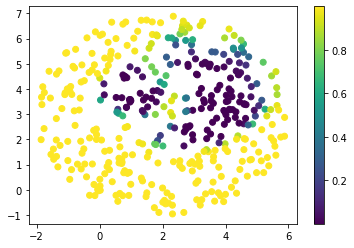

In [ ]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=model.predict(x_train))
plt.colorbar()
plt.show()